## 准备工作，安装环境和依赖

In [ ]:
# !pip install -r requirements.txt

In [ ]:
# Uncomment for colab
!pip install -q torchdata==0.3.0 torchtext==0.12 spacy==3.2 altair GPUtil
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 68.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.1/671.1 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 39.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.11.0 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.11.0 which is incompatible.
en-core-web-sm 3.4.1 requ

## 依赖引入

In [ ]:
import os # 标准库，主要用于处理文件和目录路径
from os.path import exists # 引入 os.path 库中的 exists 函数，该函数用于检查给定路径的文件或目录是否存在
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad # 引入 log_softmax 和 pad 函数，前者用于对给定张量求自然对数的 softmax，后者用于对张量进行 zero-padding
import math
import copy # 提供了深浅拷贝相关的操作
import time
from torch.optim.lr_scheduler import LambdaLR # 提供了学习率调整的一种方式，通过定义一个 lambda 函数实现
import pandas as pd # 主要用于数据分析和清洗
import altair as alt # 主要用于数据可视化
from torchtext.data.functional import to_map_style_dataset # 引入 to_map_style_dataset 函数，它用于将数据转换为 Map 类型的数据集
from torch.utils.data import DataLoader # 数据读取工具，可以方便地读入数据并进行批次处理
from torchtext.vocab import build_vocab_from_iterator # 它用于从迭代器构建词汇表
import torchtext.datasets as datasets # 提供了一些预先准备好的数据集
import spacy # 自然语言处理库
import GPUtil # 用于监控 GPU 状态
import warnings 
from torch.utils.data.distributed import DistributedSampler # 用于在分布式训练中均衡地读取数据
import torch.distributed as dist # 用于支持分布式训练
import torch.multiprocessing as mp # 用于支持多进程
from torch.nn.parallel import DistributedDataParallel as DDP # 用于在分布式训练中并行运算

# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore") # 用于忽略警告信息
RUN_EXAMPLES = True # 全局变量

## 全局helper函数定义

In [ ]:
# Some convenience helper functions used throughout the notebook

# 函数用于检测当前是否在交互式 Notebook 中运行代码。如果是，返回 True，否则返回 False
def is_interactive_notebook(): 
    return __name__ == "__main__"

# 用于控制是否执行给定的函数和参数
# 当代码在交互式 Notebook 中运行且 RUN_EXAMPLES 为 True 时，执行该函数和参数，并返回该函数的输出
def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)

# 用于控制是否执行给定的函数和参数
# 当代码在交互式 Notebook 中运行且 RUN_EXAMPLES 为 True 时，执行该函数和参数，不返回任何输出
def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)

# 一个优化器的虚拟实现
# 它没有任何实际优化功能，仅用于方便实验和调试
class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None

# 一个调度器的虚拟实现
# 它没有任何实际调度功能，仅用于方便实验和调试
class DummyScheduler:
    def step(self):
        None

## 模型概述

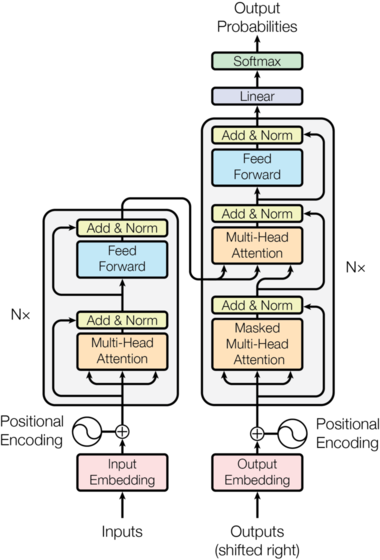

- 整个模型由两个主要部分组成
- 左侧是 encoder component
- 右侧是 decoder component
- encoder comp 和 decoder comp之间通过 encoder 的输出作为链接
- 无论是encoder comp 还是 decoder comp，输入均需要经过 input embedding 和 positional encoding 进行转化
- encoder component 由 6 层 encoder layer 构成
  - encoder layer 由 两个 sublayer (MH-Attention 和 Feed Forward) 和 两个 sublayerConnection(add&nrom)构成
- decoder component 由 6 层 decoder layer 构成
  - decoder layer 由 三个 sublayer (masked MH-Attention, encoder-decoder-Attention 和 Feed Forward) 和 三个 sublayerConnection(add&norm) 构成
- decoder layer 的最后一层的输出将会进入到一个全连接层，并接入一个softmax进行预测，得到的结果作为 decoder 下一轮的输入

## Step1 - 从输入的处理开始

In [ ]:

# 定义处理输入的 embedding 层
# embedding 层接受目标token 的维度，和字典作为初始化参数
# 接受输入的文本作为输入变量

class Embeddings(nn.Module):
  def __init__(self,d_model,vocab):
    super(Embeddings, self).__init__()
    self.d_model = d_model
    # vocab 表示词汇表的大小，该值代表了语料中出现的不同的单词的数量
    # d_model 表示词嵌入的维度，即每个单词的词向量的维度
    # embedding层的初始化过程创建了一个形状为 (vocab, d_model)的矩阵，矩阵中的每一行代表一个单词的词向量
    self.emb = nn.Embedding(vocab, d_model) 
  
  # inputBatch 是输入的文本
  # inputBatch 的维度是(batch_size, seq_len)
  # batch_size 表示一次训练/推理时使用的样本数量
  # seq_len 表示语句中单词的数量
  def forward(self, inputBatch):
    # 这里将向量与模型参数的平方根相乘，可能是为了标准化
    # self.emb(inputSeq) 的输出维度为 (batch_size, seq_len, d_model)
    # 输入的语句中每个单词都被映射到了 d_model 维的词向量上
    return self.emb(inputBatch) * math.sqrt(self.d_model)


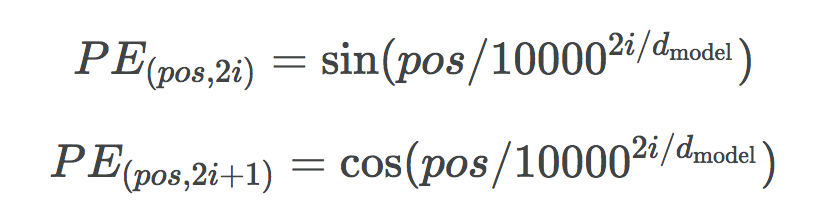

In [ ]:
# 定义embedding层之后的positional encoding
# pe接收wordembedding的结果作为输入
# pe与wordembedding 的d_model 维度是一致的
# pe的结果 + wordembedding 的结果向量相加 = 输出
# 计算公式如上图
# 详细的原理推导见pdf文档
# 同时在对于输出的结果，会采用dropout随机失活一部分参数，比例在0.1

class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout, max_len = 5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p = dropout)
    # 创建一个 5000 x 模型参数的填充张量，二维
    pe = torch.zeros(max_len, d_model)
    # 创建一个 二维张量，第二维是从0到max_len的数字， 维度是[maxlength,1]
    position = torch.arange(0, max_len).unsqueeze(1)
    # 在对数空间中解决sin函数的参数问题
    # 首先是创建一个1维度的张量，其元素依次为 [0, 2, 4, ..., d_model - 2]
    # 括号内的参数转化为 [- 0 x ln(10000) / d_model, -2 x ln(10000) / d_model...]
    # 再次经过exp 函数，转化为 [1, 1 / 10000^(2/d_model), 1/ 10000^(4/d_model)...]
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)) # 维度 [d_model/2]
    # pos [maxlength,1] x div_term [d_model/2]  = [maxLength, d_model/2]
    pe[:, 0::2] = torch.sin(position * div_term) # 偶数位使用sin函数
    pe[:, 1::2] = torch.cos(position * div_term) # 奇数位使用cos函数
    pe = pe.unsqueeze(0) # 转化为张量[1, max_len, d_model]
    self.register_buffer("pe", pe) # 在一个模块中注册一个张量作为模块的缓存。缓存是与模块相关联的张量，用作模型在前向传递期间的持久存储
  
  # 输入x + positionalEncoding的结果，再进行dropout
  def forward(self, x):
        # requires_grad 属性控制是否对 tensor 进行梯度计算，即是否参与反向传播。如果将 requires_grad 设置为 False，则表示对该 tensor 进行的任何操作不会被计入梯度，也不会参与反向传播
        # positional encoding一旦完成计算就不会发生改变，无需再纳入BP范畴
        #  结果是一个形状为 [1, seq_leength, 5] 的张量
        x = x + self.pe[:, : x.size(1)].requires_grad_(False) 
        return self.dropout(x)

In [ ]:

# 位置编码将添加一个基于位置的正弦波。波的频率和偏移对于每个维度都是不同的

def example_positional_encoding():
  pe = PositionalEncoding(20, 0) # d_model 维度是20，dropout 为 0
  y = pe.forward(torch.zeros(1, 100, 20)) # 接受一个张量 ，batch_size 为1, sequence_length = 100, d_model = 20
  print(y)
  print(y.shape) # 经过Positional encoding 之后的结果 维度为 ([1, 100, 20]) 1个batchsize，100的 sequence length， 20个d_model
  data = pd.concat(
        [
            # 创建一个三列的 dataframe 
            # 三列的名称分别为："embedding"、"dimension"、"position"
            # "embedding" 列的数据来自 y 矩阵的第一行，第 dim 维
            # "dimension" 列的数据为当前循环变量 dim 的值 4,5,6,7
            # "position" 列的数据是一个长度为 100 的数字列表，表示位置
            # 组成在一起构成 4个dim 的dataFrame
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim], # 结果是一个大小为 100 的一维数组，其中的元素是 y 的第一维第一个数据、第二维所有元素、第三维指定维的数据(所有sequece的第dim向量)
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )
  print(data)
  # 验证不同的pos下，不同的dim具备唯一的数据表示，代表其绝对位置的唯一性
  return ( alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive() )
  
show_example(example_positional_encoding)



tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  3.8767e-01,  ...,  1.0000e+00,
           2.5119e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  7.1471e-01,  ...,  1.0000e+00,
           5.0238e-04,  1.0000e+00],
         ...,
         [ 3.7961e-01, -9.2515e-01,  7.9395e-01,  ...,  9.9813e-01,
           2.4363e-02,  9.9970e-01],
         [-5.7338e-01, -8.1929e-01,  9.6756e-01,  ...,  9.9809e-01,
           2.4614e-02,  9.9970e-01],
         [-9.9921e-01,  3.9821e-02,  9.8984e-01,  ...,  9.9805e-01,
           2.4865e-02,  9.9969e-01]]])
torch.Size([1, 100, 20])
    embedding  dimension  position
0    0.000000          4         0
1    0.157827          4         1
2    0.311697          4         2
3    0.457755          4         3
4    0.592338          4         4
..        ...        ...       ...
95   0.958504          7        95
96   0.974572          7        96
97   0.986761 

alt.Chart(...)

## 搭建 多头注意力层

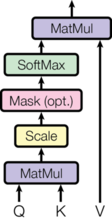

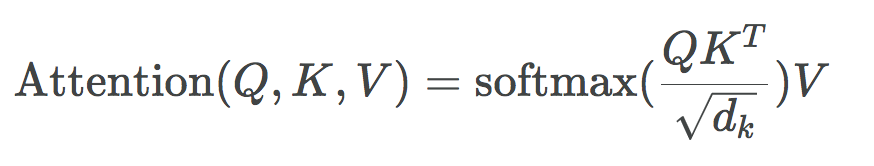

- Q向量与K向量进行矩阵相乘
- 进行规整化处理
- 基于需求进行掩码
- 进行softmax归一化
- 结果与V向量进行矩阵相乘

In [ ]:
# 定义 attention 操作

def attention(query, key, value, mask=None, dropout=None):
  d_k = query.size(-1) # 获取 query 张量最后一维的大小
  # Q矩阵与 key矩阵的的倒数第二维度和倒数第一维度的互换矩阵
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
  # mask 操作
  if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9) # mask 是一个二维向量，使用masked_fill函数将分数中等于0的值替换为-1e9（即高于任何实际数值的一个负数
  # softmax进行归一化
  p_attn = scores.softmax(dim=-1)
  # 对参数进行dropout操作
  if dropout is not None:
        p_attn = dropout(p_attn)
  return torch.matmul(p_attn, value), p_attn # 返回attention 的结果和


In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h # QKV的维度是 d_model / count of head
        self.h = h # count of head
        self.linears = clones(nn.Linear(d_model, d_model), 4) # 四个线性全连接层，输入和输出是一致的
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            # 如果你的 mask 张量的形状为 (batch_size, seq_len)，那么在第一维上执行 unsqueeze 操作后，它的形状就变为了 (batch_size, 1, seq_len)
            mask = mask.unsqueeze(1)
        nbatches = query.size(0) # Query 张量第0维度的大小

        # 1) Do all the linear projections in batch from d_model => h x d_k
        # x每次获取的分别是 query，key，value
        # 使用 lin 函数对 x 进行线性变换：lin(x)
        # 对线性变换的结果使用 view 方法重塑其形状，形状变为 (nbatches, -1, self.h, self.d_k)
        # nbatches 是批量大小
        # 头的数量
        # query/key/value 向量的维度
        # 第二维的维度由其他维的大小自动推导
        # 再将 nbatches 和 head 进行维度互换，转换为 (nbatches, self.h, - 1, self.d_k)
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        # mask 向量在最后一维才具备数据意义
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) "Concat" using a view and apply a final linear.
        # 将x向量的第一维度和第二维进行维护互换
        # 使用 contiguous 方法将 x 连续化。连续化意味着张量的内存是连续的，有利于使用 CUDA 加速等一些高效操作
        # 用 view 方法重塑张量的形状，形状变为 (nbatches, -1, self.h * self.d_k)
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        return self.linears[-1](x) # 使用最后一个全连接线性层对x进处理并返回

## 处理decoder中的mask防治attention作弊
- decoder 中的attention应当只能看到自己和自己之前的信息，而不应该看到自己身后的信息

In [ ]:
# 实现了生成「遮挡」矩阵的功能，这个矩阵用于在某些序列模型（如 Transformer 模型）中遮盖（mask）未来位置的信息
# 函数 subsequent_mask 的输入参数 size 是遮盖矩阵的尺寸。遮盖矩阵的大小是 attn_shape，它是一个三维的张量，每一维的大小分别是 1, size, size
# torch.triu(torch.ones(attn_shape), diagonal=1) 生成一个三角形的矩阵，其中参数 diagonal=1 表示对角线上方的元素都为 1。接下来，使用 .type(torch.uint8) 转换矩阵元素的数据类型为 torch.uint8
# 使用 subsequent_mask == 0 返回一个逻辑矩阵，其中对角线上方的位置的值为 0，其余位置的值为 1
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

In [ ]:
# 掩码功能的实现展示
def example_mask():
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Subsequent Mask": subsequent_mask(20)[0][x, y].flatten(), # 获取第0维下，[x,y]像素位置的值1或0
                    "Window": y,
                    "Masking": x,
                }
            )
            for y in range(20)
            for x in range(20)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect()
        .properties(height=250, width=250)
        .encode(
            alt.X("Window:O"),
            alt.Y("Masking:O"),
            alt.Color("Subsequent Mask:Q", scale=alt.Scale(scheme="viridis")),
        )
        .interactive()
    )


show_example(example_mask)

alt.Chart(...)

## 搭建 encoder component

In [ ]:
# 因为无论是encoder comp 还是 decoder comp 都由多个结构相同的encoder/decoder 构成
# 定义一个 encoder/decoder layer 复制函数
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

- 每一层 encoder layer 包括
  - self-attention 层和 feed-forward层
  - 同时在self-attention 层和 feed-forward层之后都会接一个残差链接（layer normalization) 

In [ ]:
# 定义 layer Normalization
class LayerNorm(nn.Module):
  def __init__(self, features, eps = 1e-6):
    super(LayerNorm, self).__init__()
    # 创建2个全0的参数矩阵，可供训练
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps = eps

  def forward(self, x):
    # 考虑到输入参数的维度是 [batchsize, sequence_length, d_model], 这里的平均值和标准差均应当作用于d_model所在的维度
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
  

In [ ]:
# 定义 SublayerConnection
# 使用输入 + dropout(layerNorm)

class SublayerConnection(nn.Module):
  def __init__(self,size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    # 对每一个sublayer 的输入均使用标准化处理，这里没有解释原因，仅是作为结果
    return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
# 定义 feed-forward 层 全连接位置感知前馈网络
# 包含两个全连接层和一个relu激活
# FFN(x)=max(0,xW1+b1)W2 + b2

class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model, d_ff, dropout=0.1):
    super(PositionwiseFeedForward, self).__init__()
    self.w1 = nn.Linear(d_model, d_ff)
    self.w2 = nn.Linear(d_ff,d_model)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x):
    # 对输入进行第一个全连接，激活，dropout 后进入第二个全连接
    return self.w2(self.dropout(self.w1(x).relu()))

In [ ]:
# 定义 encoder layer

class EncoderLayer(nn.Module):
  def __init__(self, size, self_attn, feed_forward, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.size = size
    # 定义两层sublayer connection层
    self.sublayer = clones(SublayerConnection(size, dropout), 2)

  def forward(self, x, mask):
    # sublayerConnection 接受的参数是 x 和 sublayer
    # self-attention 层 + layerNorm -》feed
    # 这里是 self_attn 的初始化过程
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
    # 但是这里 feed-forward 层的初始化过程没有放在这里
    return self.sublayer[1](x, self.feed_forward)

In [ ]:
# 定义 encoder component

class Encoder(nn.Module):
  def __init__(self, layer, N):
    super(Encoder,self).__init__()
    # 定义有多少层 encoder comp
    self.layers = clones(layer, N)
    # 这里layer的初始化过程放在外面了
    self.norm = LayerNorm(layer.size)

  def forward(self, x, mask):
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

- 每一层 decoder layer 包括
  - self-attention 层, encoder-decoder attention 层和一个 feed-forward层
  - 同时在每层之后都会接一个残差链接（layer normalization) 

In [ ]:
# 定义 decoder layer

class DecoderLayer(nn.Module):
  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super(DecoderLayer, self).__init__()
    self.size = size
    self.self_attn = self_attn
    self.src_attn = src_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 3) #每一个decoder layer 中都有3个sublayer层 + layerNorm

  def forward(self, x, memory, src_mask, tgt_mask):
     # 每一层sublayer 之间均有 layerNorm
     # 第一层sublayer multi-self-attention
     x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
     # 第二层sublayer encoder-decoder-attention
     x = self.sublayer[1](x, lambda x: self.src_attn(x, memory, memory, src_mask))
     # 第三层sublayer feed-forward
     return self.sublayer[2](x, self.feed_forward)

In [ ]:
# 定义 decoder component
class Decoder(nn.Module):
    "Generic N layer decoder with masking."

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    # self-attention 接受target mask
    # encoder-decoder 层接受 src_mask
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

# 串联 encoder decoder 进行模型构建

In [ ]:
# 作用是实现标准的线性变换加 softmax 生成步骤
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab) # 输入的维度 d_model 映射到输出的维度 vocab

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1) # 对线性变换的结果应用 log softmax，并在最后一维（即 dim=-1）上计算

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        # decode 过程之前需要先进行 encode 过程
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
# 定义模型

def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model) # 初始化多头注意力层
    ff = PositionwiseFeedForward(d_model, d_ff, dropout) # 初始化 Feed forward 层
    position = PositionalEncoding(d_model, dropout) # 初始化 Positional Encoding
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)), # encoder输入文本词向量 + PE
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)), # decoder输入文本词向量 + PE
        Generator(d_model, tgt_vocab), # 提供模型参数与字典，用于encoder最后一步内容的输出
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    # 通过循环来遍历每一个参数 (p)，如果该参数是多维张量 (即 p.dim() > 1)，则使用 Xavier 初始化方法 (nn.init.xavier_uniform_) 对该参数进行初始化
    # Xavier 初始化方法是一种用于初始化神经网络权值的常见方法
    # 它的目的是使得每一层的输入信号和输出信号的方差相等。
    # 这能够帮助防止梯度消失 (Vanishing Gradients) 和梯度爆炸 (Exploding Gradients) 问题
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

## 使用没有训练的模型进行数据推断

In [ ]:
# 定义一个推理测试函数
def inference_test():
    # 创建一个模型，参数分别为：输入维度，输出维度，层数
    test_model = make_model(11, 11, 2)
    
    # 将模型设置为评估模式
    test_model.eval()
    
    # 定义一个测试数据源张量，shape 为 1x10
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    
    # 定义一个源数据掩码张量，shape 为 1x1x10
    src_mask = torch.ones(1, 1, 10)

    # 对源数据进行编码
    memory = test_model.encode(src, src_mask)
    
    # 初始化解码器输入张量 ys，shape 为 1x1，填充为 0
    ys = torch.zeros(1, 1).type_as(src)

    # 循环执行解码操作，最多进行9次
    for i in range(9):
        # 对已有的序列进行解码
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        # 将解码器输出传递给生成器
        prob = test_model.generator(out[:, -1])
        
        # 获取生成器输出中概率最大的单词
        _, next_word = torch.max(prob, dim=1)
        
        # 将选择的单词转换为数据张量
        next_word = next_word.data[0]
        
        # 将新选择的单词添加到已有的序列中
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    # 打印未经训练的模型的预测结果
    print("Example Untrained Model Prediction:", ys)


# 定义一个运行推理测试的函数
def run_tests():
    # 循环执行 10 次推理测试
    for _ in range(10):
        inference_test()

# 显示运行推理测试的结果
show_example(run_tests)


Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 8, 5, 8, 5, 8, 5, 8, 5, 8]])
Example Untrained Model Prediction: tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
Example Untrained Model Prediction: tensor([[ 0,  4, 10,  6,  6,  6,  6,  6,  6,  6]])
Example Untrained Model Prediction: tensor([[0, 8, 1, 1, 1, 9, 8, 0, 1, 9]])
Example Untrained Model Prediction: tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Example Untrained Model Prediction: tensor([[0, 9, 9, 9, 9, 9, 9, 9, 9, 9]])
Example Untrained Model Prediction: tensor([[0, 4, 0, 4, 0, 4, 0, 4, 0, 4]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 8, 4, 3, 6]])
Example Untrained Model Prediction: tensor([[0, 5, 6, 3, 3, 3, 3, 3, 3, 3]])


## 模型训练过程

In [1]:
class Batch:
    """用于在训练过程中保存带有掩码的一批数据的对象。"""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        # 初始化源数据
        self.src = src
        
        # 创建源数据掩码，用于屏蔽填充符
        self.src_mask = (src != pad).unsqueeze(-2)
        
        # 如果有目标数据，则进行以下处理
        if tgt is not None:
            # 去除目标数据最后一个词
            self.tgt = tgt[:, :-1]
            
            # 去除目标数据第一个词
            self.tgt_y = tgt[:, 1:]
            
            # 创建目标数据掩码，用于屏蔽填充符和未来词汇
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            
            # 计算非填充词汇的数量
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        """创建一个掩码以隐藏填充和未来的单词。"""
        
        # 创建目标数据掩码，用于屏蔽填充符
        tgt_mask = (tgt != pad).unsqueeze(-2)
        
        # 将目标数据掩码与后续掩码相与，以屏蔽填充符和未来词汇
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        
        return tgt_mask


In [ ]:
class TrainState:
    """跟踪处理过程中的步数、示例数和词汇数"""

    step: int = 0  # 当前轮次中的步数
    accum_step: int = 0  # 梯度累积步数
    samples: int = 0  # 总共使用的样本数
    tokens: int = 0  # 处理过程中的总词汇数


In [ ]:
def run_epoch(
    data_iter,  # 数据迭代器
    model,  # 模型
    loss_compute,  # 损失计算函数
    optimizer,  # 优化器
    scheduler,  # 学习率调度器
    mode="train",  # 运行模式：训练或日志
    accum_iter=1,  # 梯度累积迭代次数
    train_state=TrainState(),  # 训练状态对象
):
    """训练一个轮次"""
    start = time.time()  # 记录开始时间
    total_tokens = 0  # 总词汇数
    total_loss = 0  # 总损失
    tokens = 0  # 当前批次的词汇数

    # 初始化梯度累积计数器
    n_accum = 0

    # 遍历数据迭代器
    for i, batch in enumerate(data_iter):
        # 前向传播
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        
        # 计算损失
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)

        # 如果运行模式为 "train" 或 "train+log"
        if mode == "train" or mode == "train+log":
            # 反向传播
            loss_node.backward()

            # 更新训练状态
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens

            # 如果当前迭代次数是梯度累积迭代次数的倍数
            if i % accum_iter == 0:
                # 更新参数
                optimizer.step()

                # 清空梯度
                optimizer.zero_grad(set_to_none=True)

                # 更新梯度累积计数器
                n_accum += 1
                train_state.accum_step += 1

            # 更新学习率
            scheduler.step()

        # 更新总损失和总词汇数
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens

        # 如果当前迭代次数是 40 的倍数，且运行模式为 "train" 或 "train+log"
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            # 获取当前学习率
            lr = optimizer.param_groups[0]["lr"]

            # 计算经过时间
            elapsed = time.time() - start

            # 打印训练信息
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )

            # 重置开始时间和当前
            start = time.time()
            tokens = 0

        # 释放损失变量和损失节点的内存
        del loss
        del loss_node

    # 返回平均损失和训练状态
    return total_loss / total_tokens, train_state


## 优化器

In [ ]:
def rate(step, model_size, factor, warmup):
    """
    为了避免零的负幂，我们需要将步骤默认设置为 1，以供 LambdaLR 函数使用。
    """
    # 如果步数为0，则将步数设置为1
    if step == 0:
        step = 1

    # 计算学习率
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )


In [ ]:
def example_learning_schedule():
    # 定义三个不同的参数组合
    opts = [
        [512, 1, 4000],  # 示例 1
        [512, 1, 8000],  # 示例 2
        [256, 1, 4000],  # 示例 3
    ]

    # 创建一个虚拟模型
    dummy_model = torch.nn.Linear(1, 1)
    learning_rates = []

    # 遍历三个参数组合
    for idx, example in enumerate(opts):
        # 对每个示例运行 20000 个轮次
        optimizer = torch.optim.Adam(
            dummy_model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9
        )
        lr_scheduler = LambdaLR(
            optimizer=optimizer, lr_lambda=lambda step: rate(step, *example)
        )
        tmp = []
        # 执行 20K 个虚拟训练步骤，保存每个步骤的学习率
        for step in range(20000):
            tmp.append(optimizer.param_groups[0]["lr"])
            optimizer.step()
            lr_scheduler.step()
        learning_rates.append(tmp)

    learning_rates = torch.tensor(learning_rates)

    # 允许 altair 处理超过 5000 行的数据
    alt.data_transformers.disable_max_rows()

    # 将数据整合为 pandas 数据帧
    opts_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Learning Rate": learning_rates[warmup_idx, :],
                    "model_size:warmup": ["512:4000", "512:8000", "256:4000"][
                        warmup_idx
                    ],
                    "step": range(20000),
                }
            )
            for warmup_idx in [0, 1, 2]
        ]
    )

    # 使用 altair 绘制学习率调度图
    return (
        alt.Chart(opts_data)
        .mark_line()
        .properties(width=600)
        .encode(x="step", y="Learning Rate", color="model_size:warmup:N")
        .interactive()
    )

# 调用函数并显示学习率调度示例图
example_learning_schedule()


## 正则化

In [ ]:
class LabelSmoothing(nn.Module):
    "实现标签平滑"

    def __init__(self, size, padding_idx, smoothing=0.0):
        # 调用父类构造函数
        super(LabelSmoothing, self).__init__()
        # 定义损失函数：Kullback-Leibler 散度损失
        self.criterion = nn.KLDivLoss(reduction="sum")
        # 定义填充索引
        self.padding_idx = padding_idx
        # 设置置信度
        self.confidence = 1.0 - smoothing
        # 设置平滑因子
        self.smoothing = smoothing
        # 设置类别数量
        self.size = size
        # 初始化真实分布
        self.true_dist = None

    def forward(self, x, target):
        # 检查输入 x 的维度是否正确
        assert x.size(1) == self.size
        # 复制输入 x 的数据
        true_dist = x.data.clone()
        # 用平滑值填充真实分布
        true_dist.fill_(self.smoothing / (self.size - 2))
        # 使用置信度更新真实分布
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        # 将填充索引的列设置为 0
        true_dist[:, self.padding_idx] = 0
        # 找到目标中填充索引的位置
        mask = torch.nonzero(target.data == self.padding_idx)
        # 如果存在填充索引，将相应行的真实分布设为 0
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        # 保存真实分布
        self.true_dist = true_dist
        # 返回损失值
        return self.criterion(x, true_dist.clone().detach())


In [ ]:
# 标签平滑示例
def example_label_smoothing():
    # 创建一个标签平滑对象，类别数量为5，填充索引为0，平滑因子为0.4
    crit = LabelSmoothing(5, 0, 0.4)
    # 定义预测值
    predict = torch.FloatTensor(
        [
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
        ]
    )
    # 计算标签平滑后的损失
    crit(x=predict.log(), target=torch.LongTensor([2, 1, 0, 3, 3]))
    # 将真实分布数据转换为 DataFrame 格式
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "target distribution": crit.true_dist[x, y].flatten(),
                    "columns": y,
                    "rows": x,
                }
            )
            for y in range(5)
            for x in range(5)
        ]
    )

    # 使用 Altair 绘制热力图展示标签平滑后的目标分布
    return (
        alt.Chart(LS_data)
        .mark_rect(color="Blue", opacity=1)
        .properties(height=200, width=200)
        .encode(
            alt.X("columns:O", title=None),
            alt.Y("rows:O", title=None),
            alt.Color(
                "target distribution:Q", scale=alt.Scale(scheme="viridis")
            ),
        )
        .interactive()
    )

# 展示标签平滑示例
show_example(example_label_smoothing)


In [ ]:
# 定义损失函数
def loss(x, crit):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    return crit(predict.log(), torch.LongTensor([1])).data

# 惩罚可视化函数
def penalization_visualization():
    # 创建一个标签平滑对象，类别数量为5，填充索引为0，平滑因子为0.1
    crit = LabelSmoothing(5, 0, 0.1)
    # 生成损失数据
    loss_data = pd.DataFrame(
        {
            "Loss": [loss(x, crit) for x in range(1, 100)],
            "Steps": list(range(99)),
        }
    ).astype("float")

    # 使用 Altair 绘制损失函数曲线
    return (
        alt.Chart(loss_data)
        .mark_line()
        .properties(width=350)
        .encode(
            x="Steps",
            y="Loss",
        )
        .interactive()
    )

# 显示惩罚可视化结果
show_example(penalization_visualization)


## Mini sample

- 尝试一个简单的复制任务开始。给定来自小词汇表的一组随机输入符号，目标是生成回那些相同的符号

In [ ]:
def data_gen(V, batch_size, nbatches):
    """
    为 src-tgt 复制任务生成随机数据。

    参数：
    V -- 词汇表大小
    batch_size -- 每个批次的样本数量
    nbatches -- 生成批次的数量
    """
    for i in range(nbatches):
        # 生成一个 batch_size x 10 的随机整数张量，整数范围为 [1, V)
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1  # 将每个样本的第一个位置设置为1（起始符）
        src = data.requires_grad_(False).clone().detach()  # 生成源数据
        tgt = data.requires_grad_(False).clone().detach()  # 生成目标数据（与源数据相同）
        yield Batch(src, tgt, 0)  # 返回一个批次对象，包含源数据、目标数据和填充索引


In [ ]:
class SimpleLossCompute:
    """
    一个简单的损失计算和训练函数。

    属性：
    generator -- 生成器，用于将模型输出转换为预测概率分布
    criterion -- 损失函数，用于计算预测概率分布与真实目标之间的损失
    """

    def __init__(self, generator, criterion):
        self.generator = generator  # 初始化生成器
        self.criterion = criterion  # 初始化损失函数

    def __call__(self, x, y, norm):
        """
        计算损失并返回。

        参数：
        x -- 模型输出
        y -- 真实目标
        norm -- 归一化因子，用于缩放损失值

        返回：
        总损失值，标量损失值
        """
        x = self.generator(x)  # 使用生成器计算预测概率分布
        # 计算损失，注意要将 x 和 y 调整为合适的形状，然后使用 norm 对损失进行缩放
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss  # 返回总损失值和标量损失值


## 使用 Greedy Search 的方式生成输出

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """
    使用贪婪策略对模型进行解码。

    参数：
    model -- Transformer 模型
    src -- 源输入张量
    src_mask -- 源输入掩码
    max_len -- 解码最大长度
    start_symbol -- 开始符号，表示解码的起始位置

    返回：
    解码得到的目标序列
    """
    memory = model.encode(src, src_mask)  # 对源输入进行编码
    # 初始化目标序列，填充开始符号
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        # 对当前目标序列进行解码
        out = model.decode(
            memory,
            src_mask,
            ys,
            subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = model.generator(out[:, -1])  # 计算生成概率
        _, next_word = torch.max(prob, dim=1)  # 选择概率最大的词作为下一个词
        next_word = next_word.data[0]
        # 将选择的词添加到目标序列
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys  # 返回解码得到的目标序列


In [ ]:
def example_simple_model():
    V = 11  # 词汇表大小
    # 使用平滑标签损失函数
    criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    # 创建模型
    model = make_model(V, V, N=2)

    # 使用 Adam 优化器
    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9
    )
    # 学习率调度器
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=400
        ),
    )

    batch_size = 80
    for epoch in range(20):
        model.train()
        # 训练模型
        run_epoch(
            data_gen(V, batch_size, 20),
            model,
            SimpleLossCompute(model.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train",
        )
        model.eval()
        # 验证模型
        run_epoch(
            data_gen(V, batch_size, 5),
            model,
            SimpleLossCompute(model.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )[0]

    model.eval()
    # 输入序列
    src = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
    max_len = src.shape[1]
    src_mask = torch.ones(1, 1, max_len)
    # 输出复制序列
    print(greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0))


# execute_example(example_simple_model) # 移除注释运行
